Current Spread: 0.01 USD


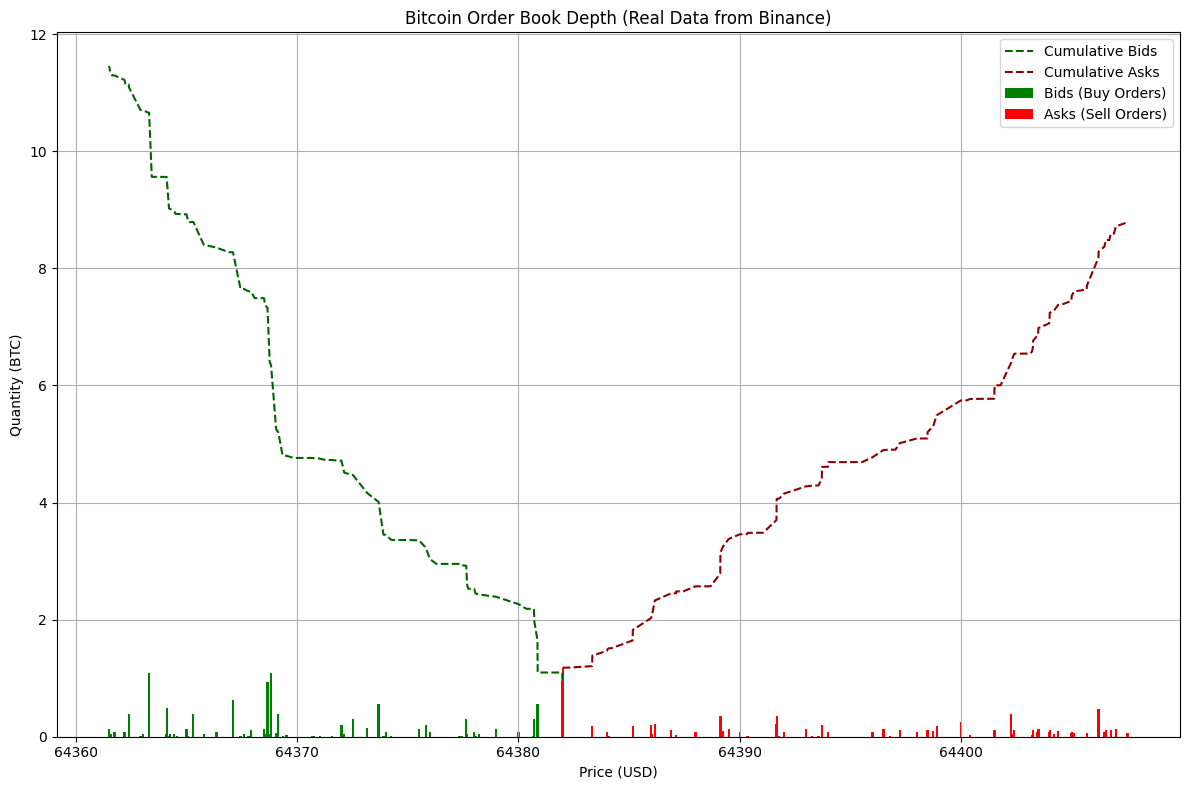

Current Spread: -4.30 USD


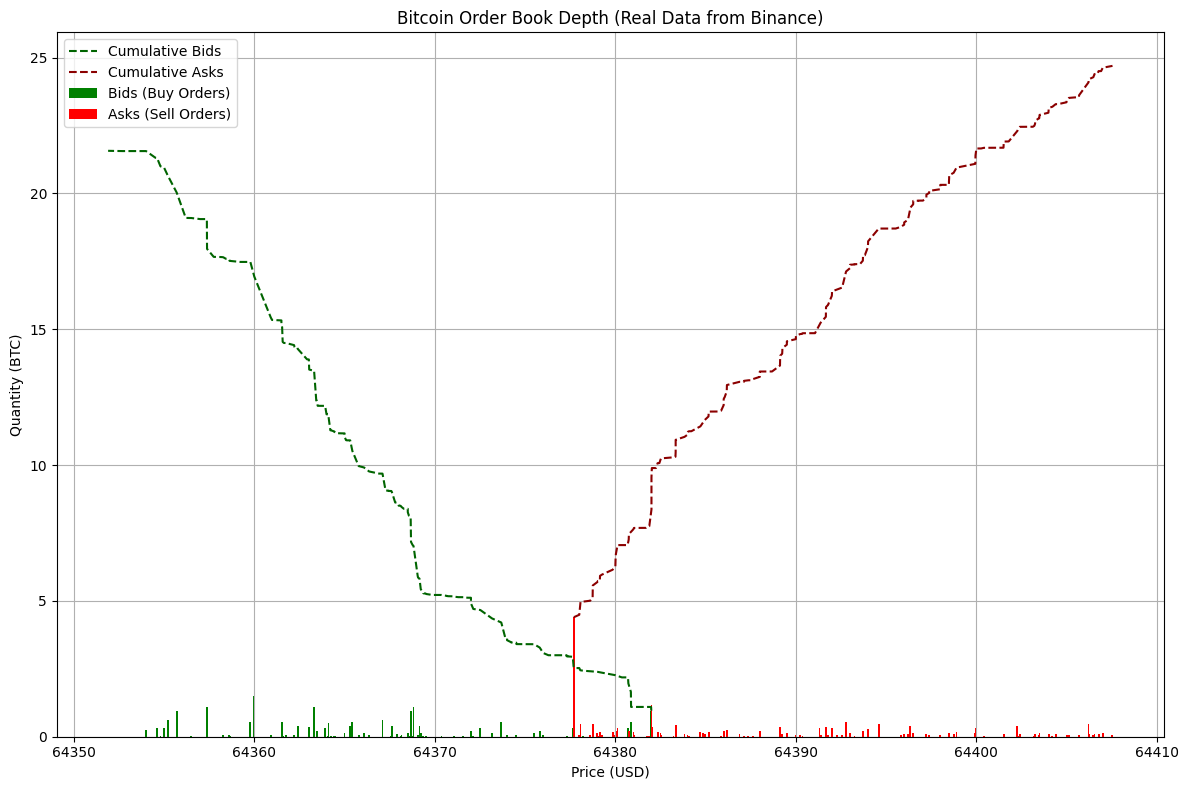

Current Spread: -27.98 USD


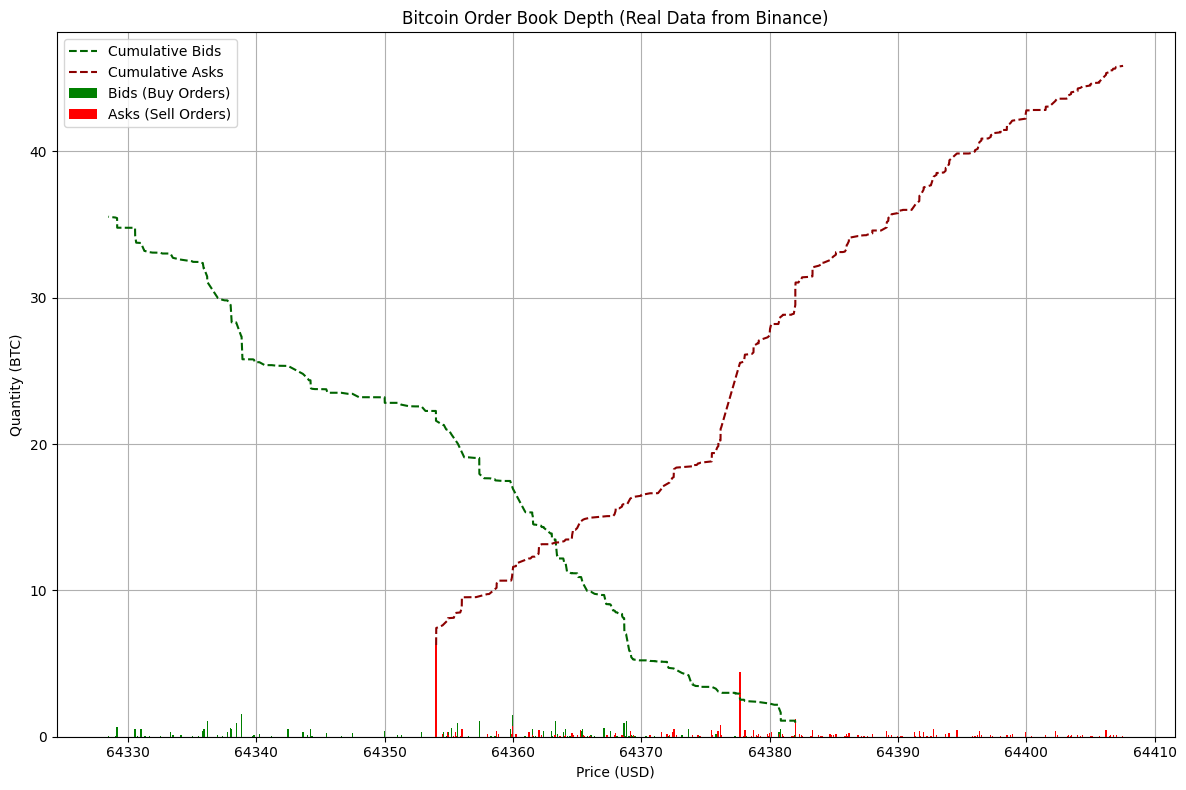

Current Spread: -31.98 USD


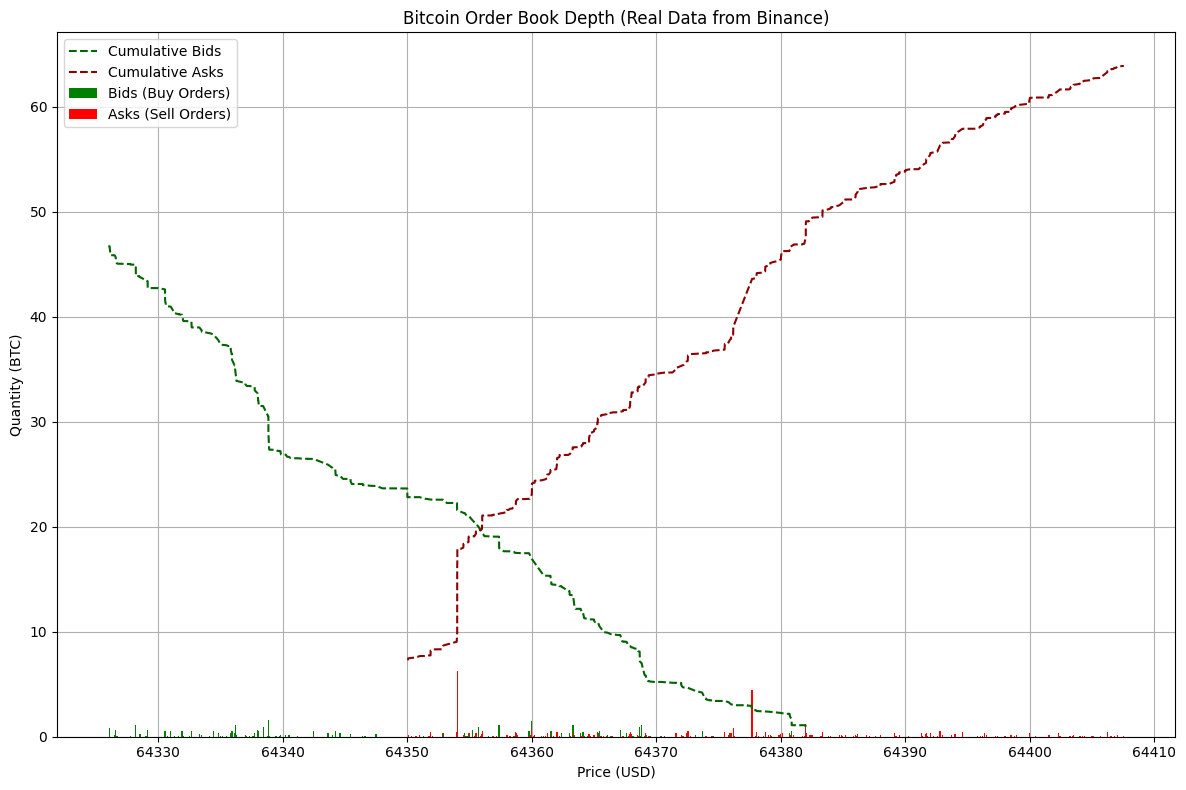

Current Spread: -31.98 USD


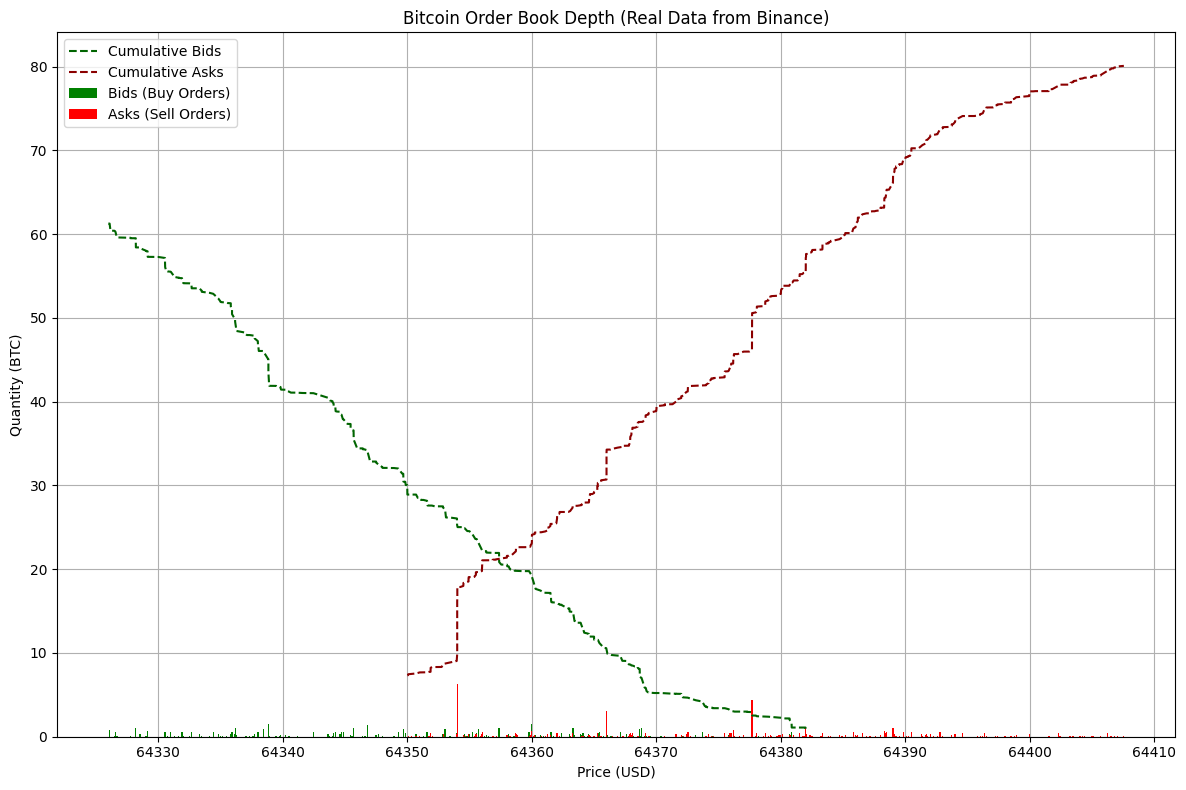

Current Spread: -31.98 USD


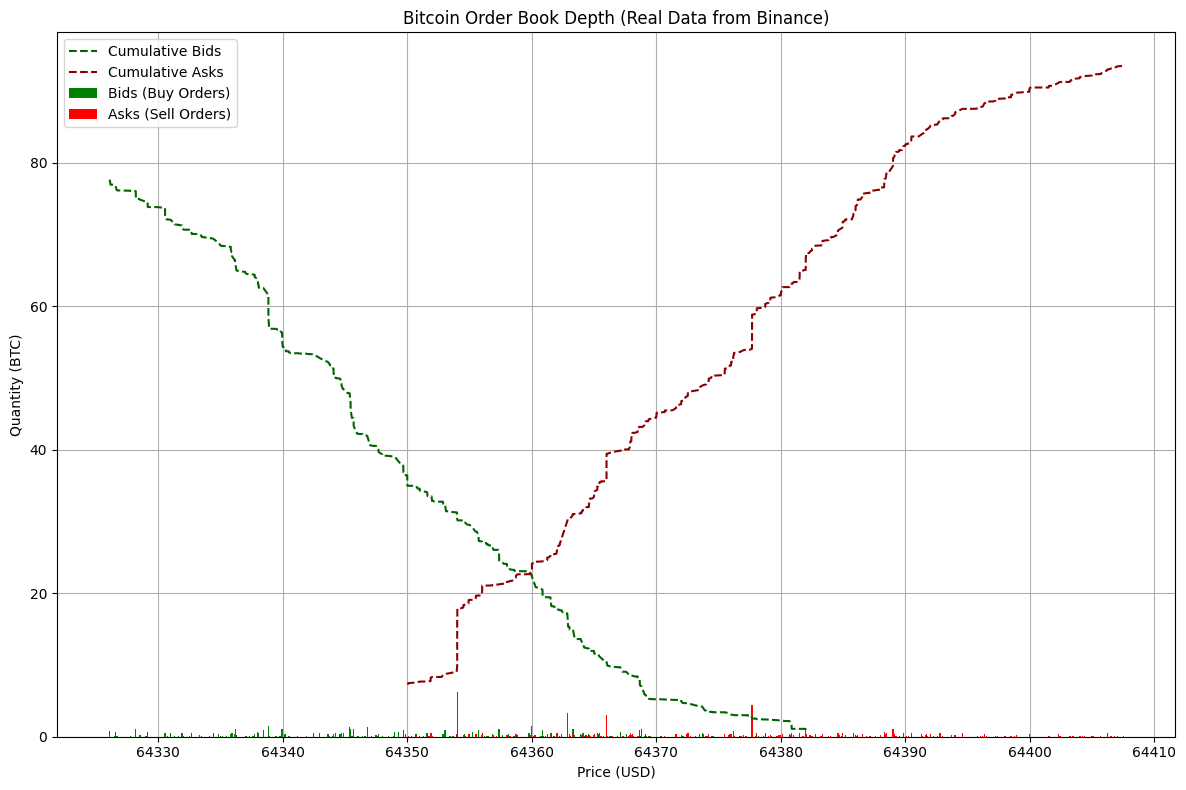

Current Spread: -31.98 USD


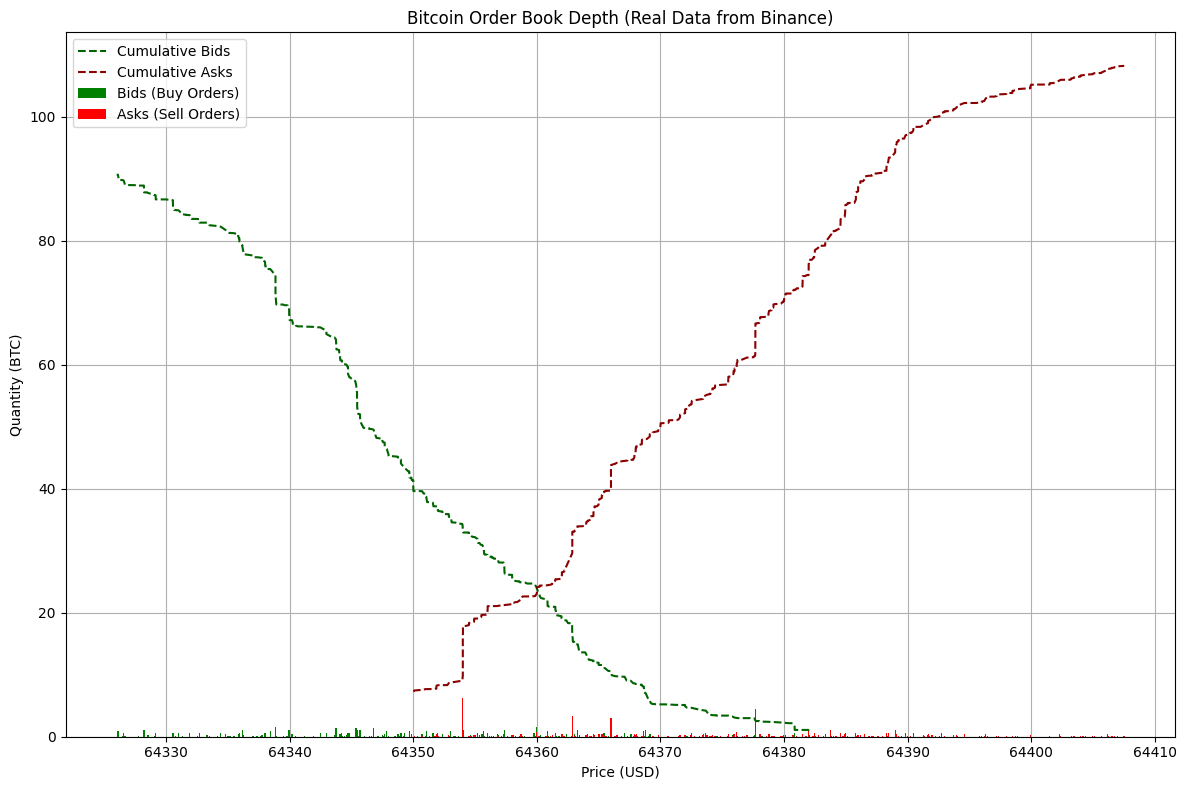

Current Spread: -31.98 USD


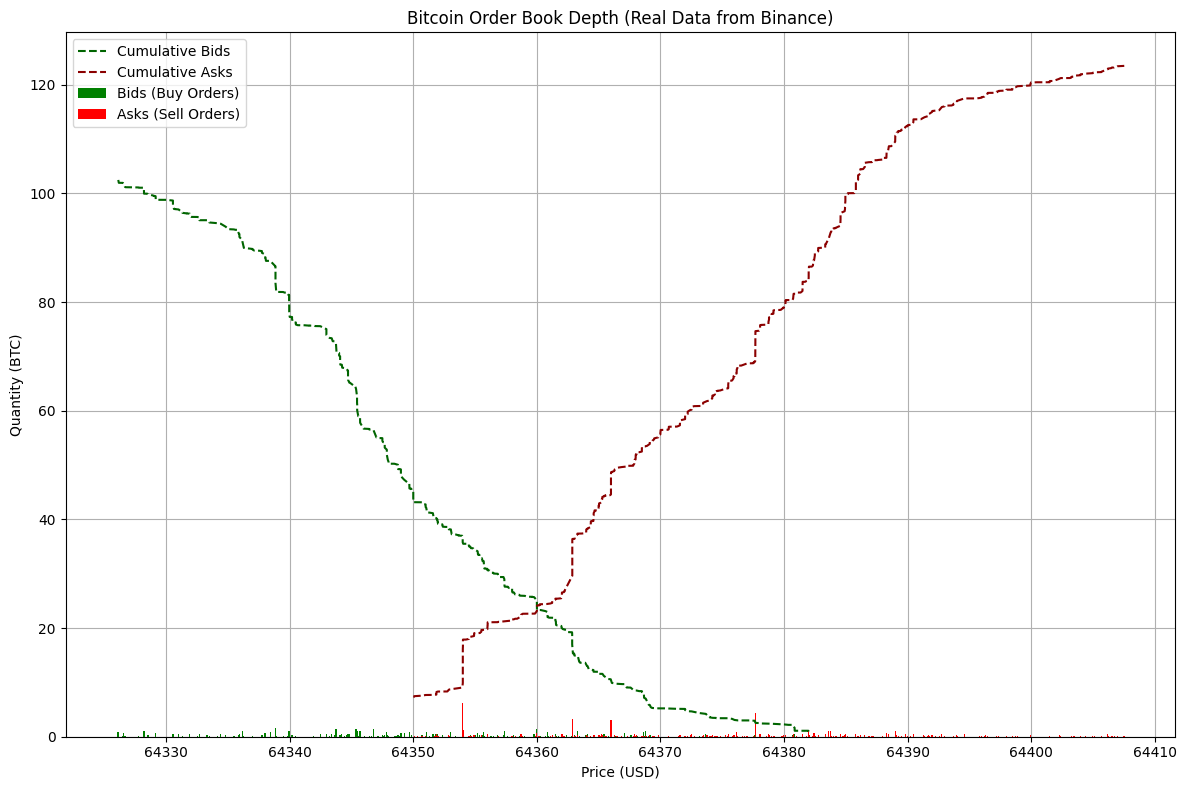

Current Spread: -31.98 USD


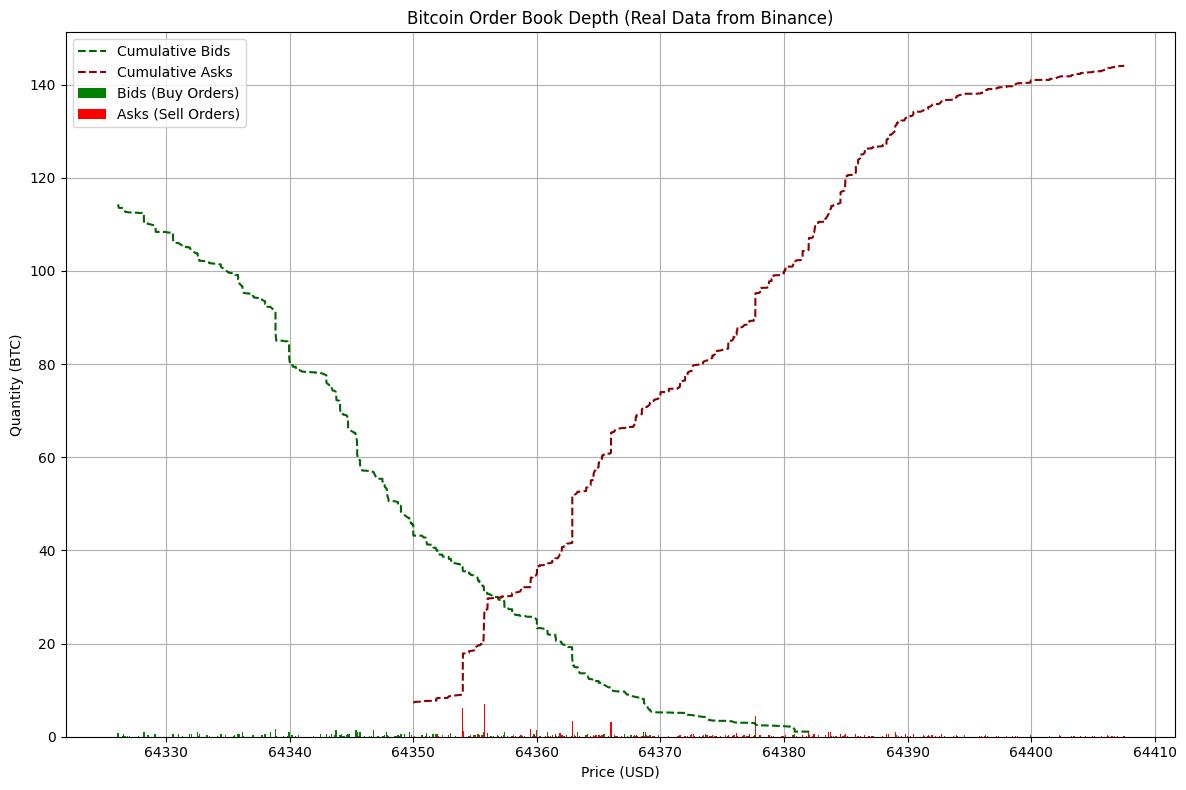

Current Spread: -31.98 USD


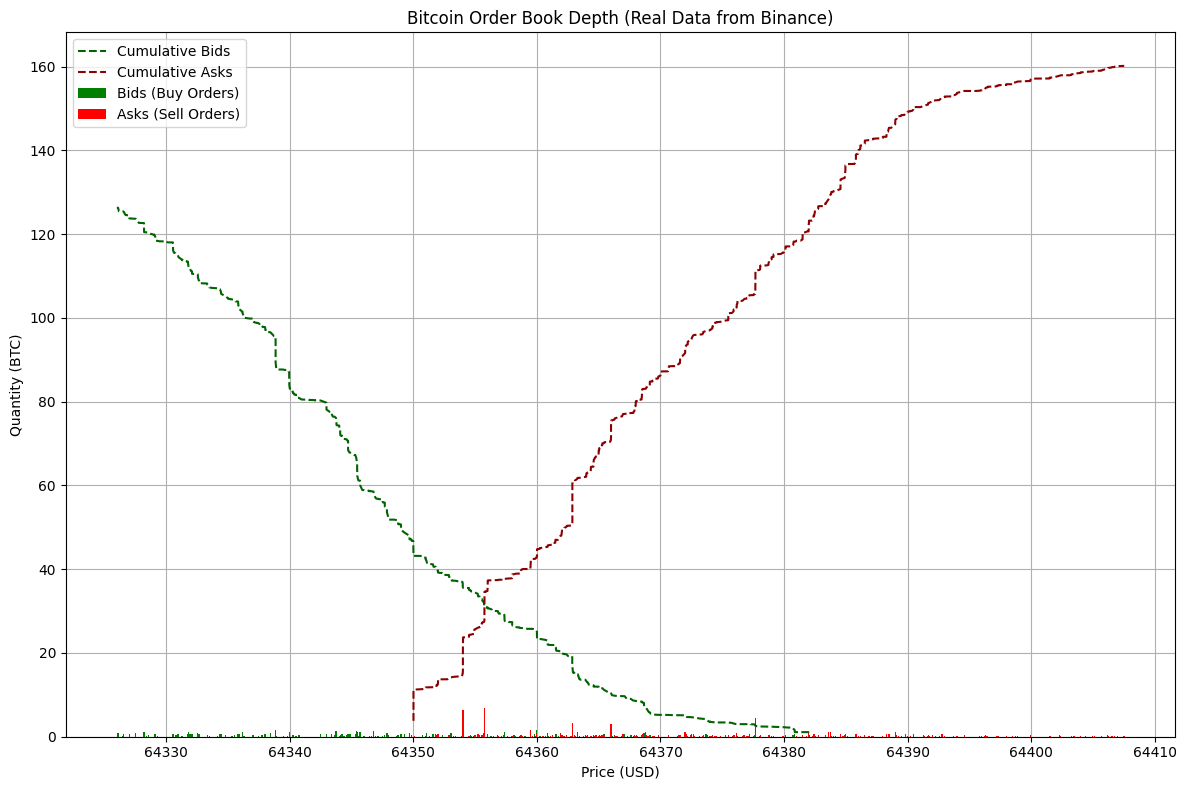

In [25]:
import requests
import heapq
import matplotlib.pyplot as plt
import time
import numpy as np

class AdvancedOrderBook:
    def __init__(self):
        self.bids = []
        self.asks = []
    
    def add_order(self, order_type, price, quantity):
        if order_type == 'buy':
            heapq.heappush(self.bids, (-price, quantity))
        elif order_type == 'sell':
            heapq.heappush(self.asks, (price, quantity))
    
    def match_order(self, order_type, price, quantity):
        matched_quantity = 0
        if order_type == 'buy':
            while self.asks and quantity > 0 and price >= self.asks[0][0]:
                best_ask_price, best_ask_quantity = heapq.heappop(self.asks)
                if quantity >= best_ask_quantity:
                    quantity -= best_ask_quantity
                    matched_quantity += best_ask_quantity
                else:
                    heapq.heappush(self.asks, (best_ask_price, best_ask_quantity - quantity))
                    matched_quantity += quantity
                    quantity = 0
        elif order_type == 'sell':
            while self.bids and quantity > 0 and price <= -self.bids[0][0]:
                best_bid_price, best_bid_quantity = heapq.heappop(self.bids)
                if quantity >= best_bid_quantity:
                    quantity -= best_bid_quantity
                    matched_quantity += best_bid_quantity
                else:
                    heapq.heappush(self.bids, (best_bid_price, best_bid_quantity - quantity))
                    matched_quantity += quantity
                    quantity = 0
        return matched_quantity
    
    def get_order_book_depth(self):
        bids = [(-price, quantity) for price, quantity in self.bids]
        asks = [(price, quantity) for price, quantity in self.asks]
        bids.sort(reverse=True)
        asks.sort()
        return bids, asks
    
    def calculate_spread(self):
        if self.bids and self.asks:
            highest_bid = -self.bids[0][0]
            lowest_ask = self.asks[0][0]
            return lowest_ask - highest_bid
        return None
    
    def calculate_cumulative_depth(self):
        bids = [(-price, quantity) for price, quantity in self.bids]
        asks = [(price, quantity) for price, quantity in self.asks]
        bids.sort(reverse=True)
        asks.sort()
        
        cumulative_bids = [(price, sum(q for _, q in bids[:i+1])) for i, (price, _) in enumerate(bids)]
        cumulative_asks = [(price, sum(q for _, q in asks[:i+1])) for i, (price, _) in enumerate(asks)]
        
        return cumulative_bids, cumulative_asks

def fetch_binance_order_book(symbol="BTCUSDT", limit=100):
    try:
        url = f"https://api.binance.com/api/v3/depth?symbol={symbol}&limit={limit}"
        response = requests.get(url)
        response.raise_for_status()
        order_book = response.json()
        return order_book
    except requests.RequestException as e:
        print(f"Error fetching order book: {e}")
        return None

def integrate_real_data(order_book, binance_data):
    if binance_data is None:
        return
    for price, quantity in binance_data['bids']:
        order_book.add_order('buy', float(price), float(quantity))
    
    for price, quantity in binance_data['asks']:
        order_book.add_order('sell', float(price), float(quantity))

def plot_order_book(bids, asks, cumulative_bids=None, cumulative_asks=None, show_cumulative=False):
    fig, ax = plt.subplots(figsize=(12, 8))

    bid_prices = [price for price, _ in bids]
    bid_quantities = [quantity for _, quantity in bids]
    ask_prices = [price for price, _ in asks]
    ask_quantities = [quantity for _, quantity in asks]
    
    ax.bar(bid_prices, bid_quantities, color='green', width=0.1, label='Bids (Buy Orders)')
    ax.bar(ask_prices, ask_quantities, color='red', width=0.1, label='Asks (Sell Orders)')
    
    if show_cumulative and cumulative_bids and cumulative_asks:
        cum_bid_prices = [price for price, _ in cumulative_bids]
        cum_bid_quantities = [quantity for _, quantity in cumulative_bids]
        cum_ask_prices = [price for price, _ in cumulative_asks]
        cum_ask_quantities = [quantity for _, quantity in cumulative_asks]
        
        ax.plot(cum_bid_prices, cum_bid_quantities, color='darkgreen', label='Cumulative Bids', linestyle='--')
        ax.plot(cum_ask_prices, cum_ask_quantities, color='darkred', label='Cumulative Asks', linestyle='--')
    
    ax.set_xlabel('Price (USD)')
    ax.set_ylabel('Quantity (BTC)')
    ax.set_title('Bitcoin Order Book Depth (Real Data from Binance)')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    order_book = AdvancedOrderBook()

    for _ in range(10):  # Update 10 times
        binance_data = fetch_binance_order_book(limit=100)
        integrate_real_data(order_book, binance_data)
        
        bids, asks = order_book.get_order_book_depth()
        cumulative_bids, cumulative_asks = order_book.calculate_cumulative_depth()
        
        spread = order_book.calculate_spread()
        print(f"Current Spread: {spread:.2f} USD")
        
        plot_order_book(bids, asks, cumulative_bids, cumulative_asks, show_cumulative=True)
        
        time.sleep(5)  # Wait 5 seconds before the next update

if __name__ == "__main__":
    main()
